In [1]:
from google.colab import drive
drive.mount("/content/drive")




Mounted at /content/drive


In [2]:
!pip install -q segment-anything opencv-python matplotlib torch torchvision


In [3]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


In [4]:
from google.colab import files
files.download("sam_vit_b_01ec64.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_b"](
    checkpoint="/content/sam_vit_b_01ec64.pth"
)
sam.to(device)

predictor = SamPredictor(sam)


In [7]:

def resize_for_sam(image, max_side=512):
    h, w = image.shape[:2]
    scale = max_side / max(h, w)

    if scale < 1:
        image = cv2.resize(
            image,
            (int(w * scale), int(h * scale)),
            interpolation=cv2.INTER_AREA
        )
    else:
        scale = 1.0

    return image, scale


In [8]:
def order_corners(pts):
    pts = np.array(pts)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    return np.array([tl, tr, br, bl])


In [9]:
def rectangularity(cnt):
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    return area / (w * h + 1e-6)

def solidity(cnt):
    area = cv2.contourArea(cnt)
    hull_area = cv2.contourArea(cv2.convexHull(cnt))
    return area / (hull_area + 1e-6)

def edge_straightness(corners):
    edges = [
        np.linalg.norm(corners[1] - corners[0]),
        np.linalg.norm(corners[2] - corners[1]),
        np.linalg.norm(corners[3] - corners[2]),
        np.linalg.norm(corners[0] - corners[3])
    ]
    return min(edges) / max(edges)


In [10]:
def is_a4_contour(cnt, img_area, tol=0.20):
    area = cv2.contourArea(cnt)
    if area < 0.08 * img_area:
        return False, None

    cnt = cv2.convexHull(cnt)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)

    if len(approx) != 4:
        return False, None

    corners = order_corners(approx.reshape(4, 2))

    w = np.linalg.norm(corners[1] - corners[0])
    h = np.linalg.norm(corners[3] - corners[0])
    if w < 40 or h < 40:
        return False, None

    ratio = max(w, h) / min(w, h)
    if abs(ratio - np.sqrt(2)) > tol:
        return False, None

    rect = rectangularity(cnt)
    if rect < 0.80 or rect > 0.98:
        return False, None

    if solidity(cnt) < 0.90:
        return False, None

    if edge_straightness(corners) < 0.65:
        return False, None

    return True, corners


In [11]:
def detect_a4_with_sam(image_bgr):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_small, scale = resize_for_sam(image_rgb)

    predictor.set_image(image_small)
    h, w, _ = image_small.shape
    img_area = h * w

    box = np.array([0.05*w, 0.05*h, 0.95*w, 0.95*h])
    points = np.array([
        [0.3*w, 0.3*h],
        [0.7*w, 0.3*h],
        [0.7*w, 0.7*h],
        [0.3*w, 0.7*h]
    ])
    labels = np.ones(len(points))

    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=labels,
        box=box,
        multimask_output=True
    )

    best_score = -1
    best_corners = None

    for mask, sam_score in zip(masks, scores):
        mask = mask.astype(np.uint8)
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            continue

        cnt = max(cnts, key=cv2.contourArea)
        ok, corners = is_a4_contour(cnt, img_area)

        if ok:
            area_ratio = cv2.contourArea(cnt) / img_area
            final_score = (
                0.30 * sam_score +
                0.25 * rectangularity(cnt) +
                0.15 * solidity(cnt) +
                0.30 * area_ratio
            )

            if final_score > best_score:
                best_score = final_score
                best_corners = corners

    if best_corners is None:
        return None

    corners = best_corners / scale
    return np.array(corners, dtype=np.int32)


In [12]:
DATASET_DIR = "/content/drive/MyDrive/shoe_dataset/Dataset"

image_files = sorted([
    f for f in os.listdir(DATASET_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])


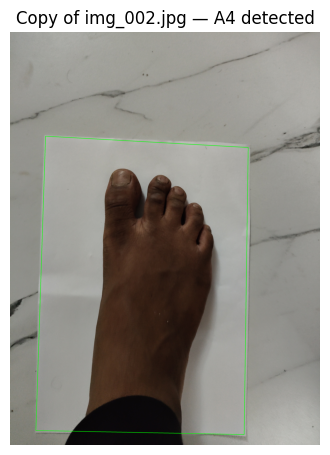

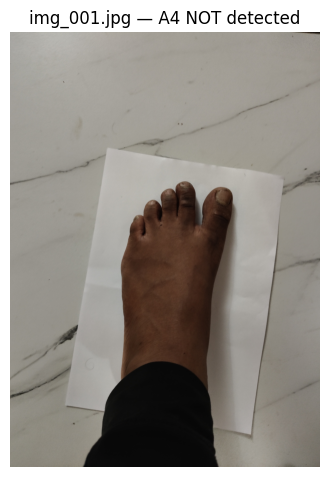

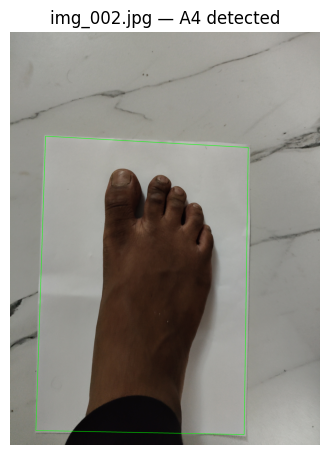

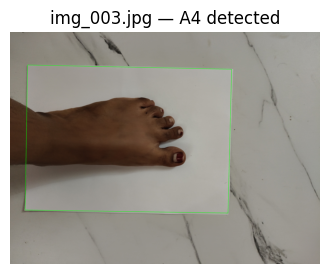

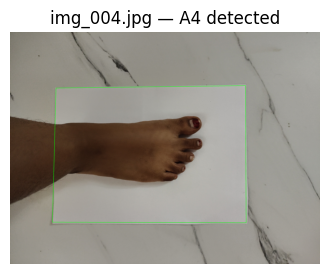

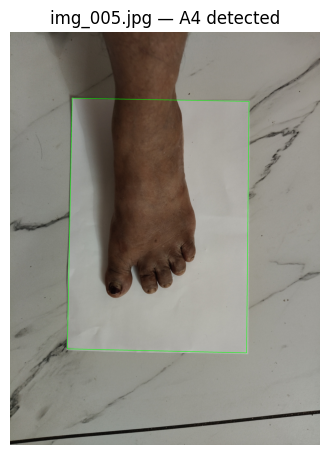

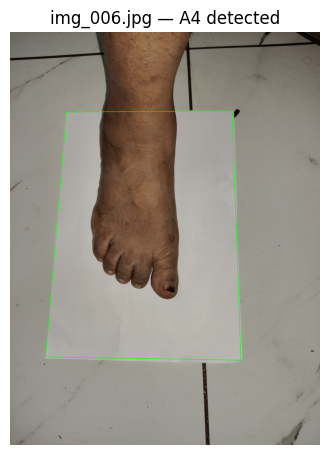

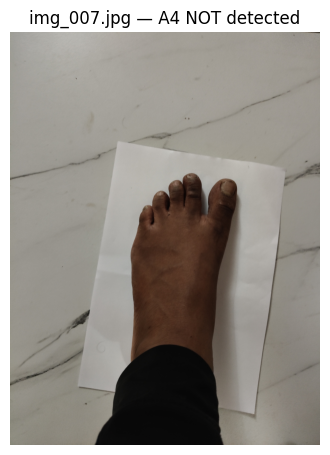

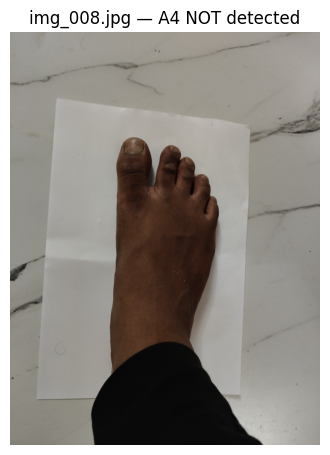

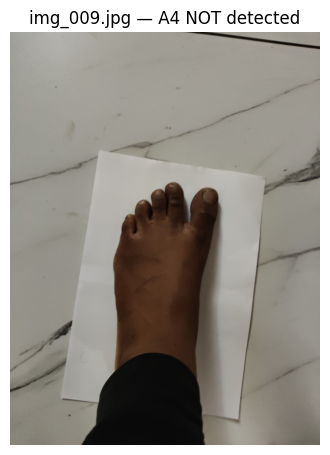

In [13]:
for fname in image_files[:10]:
    img_path = os.path.join(DATASET_DIR, fname)
    image = cv2.imread(img_path)

    if image is None:
        continue

    corners = detect_a4_with_sam(image)
    vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if corners is not None:
        pts = corners.reshape(-1, 1, 2).astype(np.int32)
        cv2.polylines(vis, [pts], True, (0, 255, 0), 3)
        title = f"{fname} — A4 detected"
    else:
        title = f"{fname} — A4 NOT detected"

    plt.figure(figsize=(4,6))
    plt.imshow(vis)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [14]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [15]:
class FootDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

        self.pairs = []

        for mask_name in os.listdir(mask_dir):
            base = os.path.splitext(mask_name)[0]

            for ext in [".jpg", ".png", ".jpeg"]:
                img_path = os.path.join(image_dir, base + ext)
                if os.path.exists(img_path):
                    mask_path = os.path.join(mask_dir, mask_name)
                    self.pairs.append((img_path, mask_path))
                    break

        print(f"✅ Valid image-mask pairs: {len(self.pairs)}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))

        image = image / 255.0
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.u1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.u2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.u3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u4 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.c1 = DoubleConv(1024, 512)
        self.c2 = DoubleConv(512, 256)
        self.c3 = DoubleConv(256, 128)
        self.c4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        d3 = self.d3(self.pool(d2))
        d4 = self.d4(self.pool(d3))

        b = self.bottleneck(self.pool(d4))

        u1 = self.c1(torch.cat([self.u1(b), d4], dim=1))
        u2 = self.c2(torch.cat([self.u2(u1), d3], dim=1))
        u3 = self.c3(torch.cat([self.u3(u2), d2], dim=1))
        u4 = self.c4(torch.cat([self.u4(u3), d1], dim=1))

        return torch.sigmoid(self.out(u4))


In [17]:
IMAGE_DIR = "/content/drive/MyDrive/shoe_dataset/Dataset"
MASK_DIR  = "/content/drive/MyDrive/shoe_dataset/Dataset/foot_masks_sam"

dataset = FootDataset(IMAGE_DIR, MASK_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


✅ Valid image-mask pairs: 98


In [18]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss/len(loader):.4f}")


Epoch [1/20] Loss: 0.5291
Epoch [2/20] Loss: 0.3654
Epoch [3/20] Loss: 0.3170
Epoch [4/20] Loss: 0.2793
Epoch [5/20] Loss: 0.2573
Epoch [6/20] Loss: 0.2430
Epoch [7/20] Loss: 0.2212
Epoch [8/20] Loss: 0.2080
Epoch [9/20] Loss: 0.2014
Epoch [10/20] Loss: 0.1960
Epoch [11/20] Loss: 0.1839
Epoch [12/20] Loss: 0.1795
Epoch [13/20] Loss: 0.1618
Epoch [14/20] Loss: 0.1603
Epoch [15/20] Loss: 0.1516
Epoch [16/20] Loss: 0.1480
Epoch [17/20] Loss: 0.1464
Epoch [18/20] Loss: 0.1361
Epoch [19/20] Loss: 0.1299
Epoch [20/20] Loss: 0.1291


In [19]:
UNET_SAVE_PATH = "unet_foot.pth"

torch.save(model.state_dict(), UNET_SAVE_PATH)
print("✅ UNet saved:", UNET_SAVE_PATH)


✅ UNet saved: unet_foot.pth


In [20]:
from google.colab import files
files.download("unet_foot.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving img_012.jpg to img_012.jpg
✅ A4 detected. mm/px ≈ 0.10145
✅ Foot Length (Heel on A4 bottom): 231.65 mm (23.17 cm)
👟 Predicted Shoe Size -> UK: 6, US: 8, EU: 39


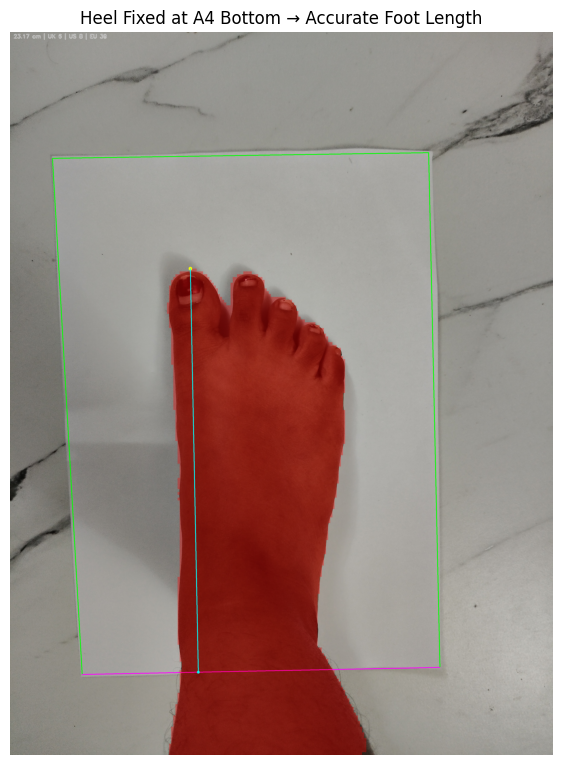

In [21]:
# ===============================
# ✅ FULL PIPELINE CELL (UPDATED)
# Heel measured from bottom edge of A4
# ===============================

from google.colab import files
import math

# -------------------------------
# Shoe size chart (approx)
# Foot length in cm -> Shoe size (UK/US/EU)
# -------------------------------
def shoe_size_from_foot_length_cm(length_cm):
    chart = [
        (21.0,  2,  4, 35),
        (21.6,  3,  5, 36),
        (22.2,  4,  6, 37),
        (22.9,  5,  7, 38),
        (23.5,  6,  8, 39),
        (24.1,  7,  9, 40),
        (24.8,  8, 10, 41),
        (25.4,  9, 11, 42),
        (26.0, 10, 12, 43),
        (26.7, 11, 13, 44),
        (27.3, 12, 14, 45),
        (28.0, 13, 15, 46),
        (28.6, 14, 16, 47),
    ]
    for max_len, uk, us, eu in chart:
        if length_cm < max_len:
            return uk, us, eu
    return chart[-1][1], chart[-1][2], chart[-1][3]



# -------------------------------
# Get mm_per_pixel from detected A4 corners
# A4 size = 210mm x 297mm
# corners order = [tl,tr,br,bl]
# -------------------------------
def compute_mm_per_px_from_a4(corners):
    top_w = np.linalg.norm(corners[1] - corners[0])
    bottom_w = np.linalg.norm(corners[2] - corners[3])
    px_w = (top_w + bottom_w) / 2.0

    left_h = np.linalg.norm(corners[3] - corners[0])
    right_h = np.linalg.norm(corners[2] - corners[1])
    px_h = (left_h + right_h) / 2.0

    mm_per_px_w = 210.0 / (px_w + 1e-6)
    mm_per_px_h = 297.0 / (px_h + 1e-6)

    return (mm_per_px_w + mm_per_px_h) / 2.0


# -------------------------------
# Run U-Net segmentation on a full image
# Returns mask in original image resolution (0/1)
# -------------------------------
def unet_segment_foot_fullres(image_bgr, model, device, img_size=256, thresh=0.5):
    model.eval()
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = image_rgb.shape[:2]

    img_resized = cv2.resize(image_rgb, (img_size, img_size))
    img_norm = img_resized / 255.0
    x = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x)[0, 0].detach().cpu().numpy()

    mask_small = (pred > thresh).astype(np.uint8)
    mask_full = cv2.resize(mask_small, (w0, h0), interpolation=cv2.INTER_NEAREST)

    kernel = np.ones((5, 5), np.uint8)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask_full


# -------------------------------
# Distance of point P from a line passing through A and B
# (perpendicular distance)
# -------------------------------
def point_to_line_distance(P, A, B):
    # line AB
    AB = B - A
    AP = P - A
    # area = |AB x AP|, distance = area / |AB|
    cross = abs(AB[0] * AP[1] - AB[1] * AP[0])
    dist = cross / (np.linalg.norm(AB) + 1e-6)
    return dist


# -------------------------------
# ✅ FOOT LENGTH FROM A4 BOTTOM EDGE (Heel anchored)
# corners order = [tl,tr,br,bl]
# bottom edge = bl -> br  (corners[3] -> corners[2])
# length_px = max perpendicular distance of foot pixels from bottom edge
# -------------------------------
def foot_length_from_a4_bottom(mask, corners):
    # bottom line points
    bl = corners[3].astype(np.float32)
    br = corners[2].astype(np.float32)

    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None, None, (bl, br)

    # compute max perpendicular distance
    max_dist = -1
    farthest_point = None

    for x, y in zip(xs, ys):
        P = np.array([x, y], dtype=np.float32)
        d = point_to_line_distance(P, bl, br)
        if d > max_dist:
            max_dist = d
            farthest_point = P

    return float(max_dist), farthest_point, (bl, br)


# ===============================
# ✅ USER UPLOAD AND RUN PIPELINE
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    image = cv2.imread(fname)

    if image is None:
        print("❌ Could not read image.")
        continue

    # -------- SAM A4 detection --------
    corners = detect_a4_with_sam(image)

    if corners is None:
        print("❌ A4 NOT detected. Please upload an image with clear A4 sheet fully visible.")
        continue

    corners = corners.astype(np.float32)
    mm_per_px = compute_mm_per_px_from_a4(corners)
    print(f"✅ A4 detected. mm/px ≈ {mm_per_px:.5f}")

    # -------- U-Net foot segmentation --------
    foot_mask = unet_segment_foot_fullres(image, model, device, img_size=256, thresh=0.5)

    # -------- FOOT LENGTH from A4 bottom edge --------
    foot_len_px, toe_point, (bl, br) = foot_length_from_a4_bottom(foot_mask, corners)

    if foot_len_px is None:
        print("❌ Foot not detected.")
        continue

    foot_len_mm = foot_len_px * mm_per_px
    foot_len_cm = foot_len_mm / 10.0
    uk, us, eu = shoe_size_from_foot_length_cm(foot_len_cm)

    print(f"✅ Foot Length (Heel on A4 bottom): {foot_len_mm:.2f} mm ({foot_len_cm:.2f} cm)")
    print(f"👟 Predicted Shoe Size -> UK: {uk}, US: {us}, EU: {eu}")

    # ===============================
    # VISUALIZATION
    # ===============================
    vis = image.copy()

    # draw A4 polygon
    pts = corners.reshape(-1, 1, 2).astype(np.int32)
    cv2.polylines(vis, [pts], True, (0, 255, 0), 3)

    # draw bottom A4 line (heel reference)
    cv2.line(
        vis,
        tuple(bl.astype(int)),
        tuple(br.astype(int)),
        (255, 0, 255),
        4
    )

    # overlay foot mask
    overlay = vis.copy()
    overlay[foot_mask == 1] = (0, 0, 255)
    vis = cv2.addWeighted(overlay, 0.35, vis, 0.65, 0)

    # draw perpendicular line to toe point (for visualization)
    if toe_point is not None:
        toe = tuple(toe_point.astype(int))
        cv2.circle(vis, toe, 10, (0, 255, 255), -1)

        # draw a line from toe to nearest point on bottom line (projection)
        # projection formula
        A = bl
        B = br
        AB = B - A
        AP = toe_point - A
        t = np.dot(AP, AB) / (np.dot(AB, AB) + 1e-6)
        proj = A + t * AB
        proj_int = tuple(proj.astype(int))

        cv2.line(vis, toe, proj_int, (255, 255, 0), 4)
        cv2.circle(vis, proj_int, 8, (255, 255, 0), -1)

    text = f"{foot_len_cm:.2f} cm | UK {uk} | US {us} | EU {eu}"
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 1)

    plt.figure(figsize=(7,10))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Heel Fixed at A4 Bottom → Accurate Foot Length")
    plt.axis("off")
    plt.show()


Saving img_012.jpg to img_012 (1).jpg
✅ A4 detected. mm/px ≈ 0.10145
✅ Foot Length (Heel on A4 bottom): 231.65 mm (23.17 cm)
📌 Raw size (before correction): UK 6, US 8, EU 39
✅ Final size (next size shown):  UK 7, US 9, EU 40


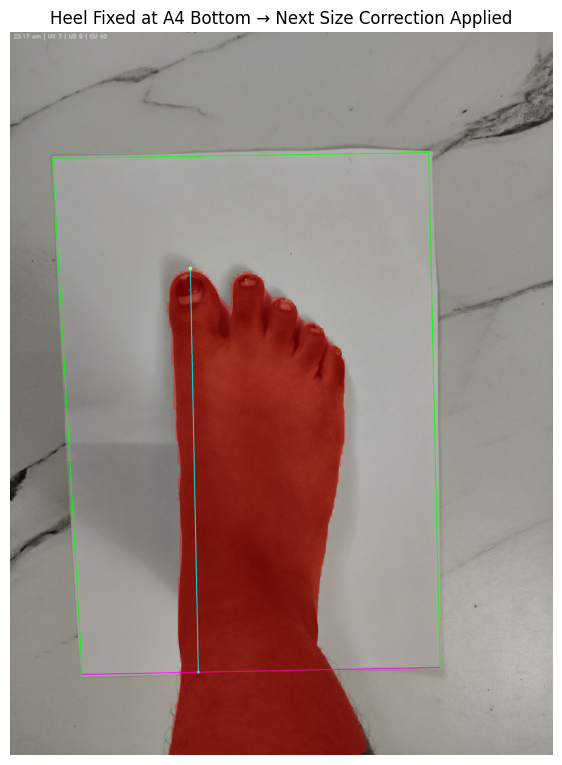

In [22]:
# ===============================
# ✅ FULL PIPELINE CELL (UPDATED)
# Heel measured from bottom edge of A4
# + NEXT SIZE correction added (fix size-down issue)
# ===============================

from google.colab import files
import math
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# -------------------------------
# Shoe size chart RAW (normal size)
# Foot length in cm -> Shoe size (UK/US/EU)
# -------------------------------
def shoe_size_raw(length_cm):
    chart = [
        (21.0,  2,  4, 35),
        (21.6,  3,  5, 36),
        (22.2,  4,  6, 37),
        (22.9,  5,  7, 38),
        (23.5,  6,  8, 39),
        (24.1,  7,  9, 40),
        (24.8,  8, 10, 41),
        (25.4,  9, 11, 42),
        (26.0, 10, 12, 43),
        (26.7, 11, 13, 44),
        (27.3, 12, 14, 45),
        (28.0, 13, 15, 46),
        (28.6, 14, 16, 47),
    ]
    for max_len, uk, us, eu in chart:
        if length_cm <= max_len:
            return uk, us, eu
    return chart[-1][1], chart[-1][2], chart[-1][3]


# -------------------------------
# ✅ Shoe size chart FINAL (Next size correction)
# -------------------------------
def shoe_size_from_foot_length_cm(length_cm):
    """
    Always returns NEXT size to avoid size-down issue.
    """
    chart = [
        (21.0,  2,  4, 35),
        (21.6,  3,  5, 36),
        (22.2,  4,  6, 37),
        (22.9,  5,  7, 38),
        (23.5,  6,  8, 39),
        (24.1,  7,  9, 40),
        (24.8,  8, 10, 41),
        (25.4,  9, 11, 42),
        (26.0, 10, 12, 43),
        (26.7, 11, 13, 44),
        (27.3, 12, 14, 45),
        (28.0, 13, 15, 46),
        (28.6, 14, 16, 47),
    ]

    for i, (max_len, uk, us, eu) in enumerate(chart):
        if length_cm <= max_len:
            # ✅ return next size if exists
            if i + 1 < len(chart):
                return chart[i + 1][1], chart[i + 1][2], chart[i + 1][3]
            return uk, us, eu

    return chart[-1][1], chart[-1][2], chart[-1][3]


# -------------------------------
# Get mm_per_pixel from detected A4 corners
# A4 size = 210mm x 297mm
# corners order = [tl,tr,br,bl]
# -------------------------------
def compute_mm_per_px_from_a4(corners):
    top_w = np.linalg.norm(corners[1] - corners[0])
    bottom_w = np.linalg.norm(corners[2] - corners[3])
    px_w = (top_w + bottom_w) / 2.0

    left_h = np.linalg.norm(corners[3] - corners[0])
    right_h = np.linalg.norm(corners[2] - corners[1])
    px_h = (left_h + right_h) / 2.0

    mm_per_px_w = 210.0 / (px_w + 1e-6)
    mm_per_px_h = 297.0 / (px_h + 1e-6)

    return (mm_per_px_w + mm_per_px_h) / 2.0


# -------------------------------
# Run U-Net segmentation on a full image
# Returns mask in original image resolution (0/1)
# -------------------------------
def unet_segment_foot_fullres(image_bgr, model, device, img_size=256, thresh=0.5):
    model.eval()
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = image_rgb.shape[:2]

    img_resized = cv2.resize(image_rgb, (img_size, img_size))
    img_norm = img_resized / 255.0
    x = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x)[0, 0].detach().cpu().numpy()

    mask_small = (pred > thresh).astype(np.uint8)
    mask_full = cv2.resize(mask_small, (w0, h0), interpolation=cv2.INTER_NEAREST)

    kernel = np.ones((5, 5), np.uint8)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask_full


# -------------------------------
# Distance of point P from a line passing through A and B
# (perpendicular distance)
# -------------------------------
def point_to_line_distance(P, A, B):
    AB = B - A
    AP = P - A
    cross = abs(AB[0] * AP[1] - AB[1] * AP[0])
    dist = cross / (np.linalg.norm(AB) + 1e-6)
    return dist


# -------------------------------
# ✅ FOOT LENGTH FROM A4 BOTTOM EDGE (Heel anchored)
# corners order = [tl,tr,br,bl]
# bottom edge = bl -> br  (corners[3] -> corners[2])
# length_px = max perpendicular distance of foot pixels from bottom edge
# -------------------------------
def foot_length_from_a4_bottom(mask, corners):
    bl = corners[3].astype(np.float32)
    br = corners[2].astype(np.float32)

    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None, None, (bl, br)

    max_dist = -1
    farthest_point = None

    for x, y in zip(xs, ys):
        P = np.array([x, y], dtype=np.float32)
        d = point_to_line_distance(P, bl, br)
        if d > max_dist:
            max_dist = d
            farthest_point = P

    return float(max_dist), farthest_point, (bl, br)


# ===============================
# ✅ USER UPLOAD AND RUN PIPELINE
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    image = cv2.imread(fname)

    if image is None:
        print("❌ Could not read image.")
        continue

    # -------- SAM A4 detection --------
    corners = detect_a4_with_sam(image)

    if corners is None:
        print("❌ A4 NOT detected. Please upload an image with clear A4 sheet fully visible.")
        continue

    corners = corners.astype(np.float32)
    mm_per_px = compute_mm_per_px_from_a4(corners)
    print(f"✅ A4 detected. mm/px ≈ {mm_per_px:.5f}")

    # -------- U-Net foot segmentation --------
    foot_mask = unet_segment_foot_fullres(image, model, device, img_size=256, thresh=0.5)

    # -------- FOOT LENGTH from A4 bottom edge --------
    foot_len_px, toe_point, (bl, br) = foot_length_from_a4_bottom(foot_mask, corners)

    if foot_len_px is None:
        print("❌ Foot not detected.")
        continue

    foot_len_mm = foot_len_px * mm_per_px
    foot_len_cm = foot_len_mm / 10.0

    # ✅ RAW size and FINAL corrected size
    raw_uk, raw_us, raw_eu = shoe_size_raw(foot_len_cm)
    uk, us, eu = shoe_size_from_foot_length_cm(foot_len_cm)

    print(f"✅ Foot Length (Heel on A4 bottom): {foot_len_mm:.2f} mm ({foot_len_cm:.2f} cm)")
    print(f"📌 Raw size (before correction): UK {raw_uk}, US {raw_us}, EU {raw_eu}")
    print(f"✅ Final size (next size shown):  UK {uk}, US {us}, EU {eu}")

    # ===============================
    # VISUALIZATION
    # ===============================
    vis = image.copy()

    # draw A4 polygon
    pts = corners.reshape(-1, 1, 2).astype(np.int32)
    cv2.polylines(vis, [pts], True, (0, 255, 0), 3)

    # draw bottom A4 line (heel reference)
    cv2.line(
        vis,
        tuple(bl.astype(int)),
        tuple(br.astype(int)),
        (255, 0, 255),
        4
    )

    # overlay foot mask
    overlay = vis.copy()
    overlay[foot_mask == 1] = (0, 0, 255)
    vis = cv2.addWeighted(overlay, 0.35, vis, 0.65, 0)

    # draw perpendicular line to toe point (for visualization)
    if toe_point is not None:
        toe = tuple(toe_point.astype(int))
        cv2.circle(vis, toe, 10, (0, 255, 255), -1)

        A = bl
        B = br
        AB = B - A
        AP = toe_point - A
        t = np.dot(AP, AB) / (np.dot(AB, AB) + 1e-6)
        proj = A + t * AB
        proj_int = tuple(proj.astype(int))

        cv2.line(vis, toe, proj_int, (255, 255, 0), 4)
        cv2.circle(vis, proj_int, 8, (255, 255, 0), -1)

    text = f"{foot_len_cm:.2f} cm | UK {uk} | US {us} | EU {eu}"
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 1)

    plt.figure(figsize=(7,10))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Heel Fixed at A4 Bottom → Next Size Correction Applied")
    plt.axis("off")
    plt.show()


In [23]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from shoe_pipeline import ShoeSizePipeline

st.set_page_config(page_title="Shoe Size Predictor", layout="wide")
st.title("👟 Shoe Size Prediction (SAM + U-Net)")

@st.cache_resource
def load_pipeline():
    return ShoeSizePipeline(
        sam_ckpt_path="sam_vit_b_01ec64.pth",
        unet_ckpt_path="unet_foot.pth"
    )

pipe = load_pipeline()

uploaded = st.file_uploader("Upload Foot Image (Heel should be on A4 bottom)", type=["jpg", "jpeg", "png"])

if uploaded is not None:
    file_bytes = np.asarray(bytearray(uploaded.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("Original Image")
        st.image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), use_container_width=True)

    with st.spinner("Running SAM + UNet..."):
        result = pipe.predict(image)

    if not result["ok"]:
        st.error(result["error"])
    else:
        with col2:
            st.subheader("Output")
            st.image(cv2.cvtColor(result["vis"], cv2.COLOR_BGR2RGB), use_container_width=True)

        st.success(f"✅ Foot Length: {result['length_cm']:.2f} cm")
        st.write(f"📌 Raw Size: UK {result['raw_size']['uk']} | US {result['raw_size']['us']} | EU {result['raw_size']['eu']}")
        st.write(f"✅ Final Size (next size): UK {result['final_size']['uk']} | US {result['final_size']['us']} | EU {result['final_size']['eu']}")
        st.caption(f"mm/px = {result['mm_per_px']:.6f}")


Writing app.py


In [24]:
from pyngrok import ngrok
import time, threading, os

# Kill any previous sessions
try:
    ngrok.kill()
except:
    pass

# Start Streamlit in background
def run_streamlit():
    os.system("streamlit run app.py --server.port 8501 --server.address 0.0.0.0")

thread = threading.Thread(target=run_streamlit)
thread.start()

time.sleep(3)

public_url = ngrok.connect(8501)
print("✅ Streamlit Public URL:", public_url)


ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
# ===============================
# ✅ FULL PIPELINE CELL (UPDATED)
# Heel measured from bottom edge of A4
# Converse actual chart mapping integrated
# ===============================

from google.colab import files
import math

# -------------------------------
# ✅ Converse Official Shoe Size Chart
# LENGTH (CM) -> US MEN, US WOMEN, UK, EU
# -------------------------------
def shoe_size_from_foot_length_cm(length_cm, mode="ceil", jack_purcell=False):
    """
    Map foot length (CM) to Converse official size chart.

    mode:
        - "nearest" : closest CM row
        - "ceil"    : picks next bigger size (recommended to avoid short size)
        - "floor"   : picks smaller size

    jack_purcell:
        True  -> half-size down recommendation (runs large)
        False -> normal size

    Returns:
        uk, us_men, eu
    """

    chart = [
        (21.0,  3.0,  4.5,  2.5, 35.0),
        (21.5,  3.5,  5.0,  3.0, 35.5),
        (22.0,  4.0,  5.5,  3.5, 36.0),
        (22.5,  4.5,  6.0,  4.0, 37.0),
        (23.0,  5.0,  6.5,  4.5, 37.5),
        (23.5,  5.5,  7.0,  5.0, 38.0),
        (24.0,  6.5,  8.0,  5.5, 39.0),
        (25.0,  7.0,  8.5,  6.0, 40.0),
        (25.5,  7.5,  9.0,  6.5, 40.5),
        (26.0,  8.0,  9.5,  7.0, 41.0),
        (26.5,  8.5, 10.0,  7.5, 42.0),
        (27.0,  9.0, 10.5,  8.0, 42.5),
        (27.5,  9.5, 11.0,  8.5, 43.0),
        (28.0, 10.0, 11.5,  9.0, 44.0),
        (28.5, 10.5, 12.0,  9.5, 44.5),
        (29.0, 11.0, 12.5, 10.0, 45.0),
        (29.5, 11.5, 13.0, 10.5, 46.0),
        (30.0, 12.0, 13.5, 11.0, 46.5),
        (30.5, 12.5, 14.0, 11.5, 47.0),
        (31.0, 13.0, 14.5, 12.0, 47.5),
        (31.5, 13.5, 15.0, 12.5, 48.0),
        (32.0, 14.0, 15.5, 13.0, 49.0),
        (32.5, 14.5, 16.0, 13.5, 49.5),
        (33.0, 15.0, 16.5, 14.0, 50.0),
        (34.0, 16.0, 17.5, 15.0, 51.5),
        (35.0, 17.0, 18.5, 16.0, 53.0),
        (36.0, 18.0, 19.5, 17.0, 54.5),
        (37.0, 19.0, 20.5, 18.0, 56.0),
        (38.0, 20.0, 21.5, 19.0, 57.5),
        (39.0, 21.0, 22.5, 20.0, 59.0),
        (40.0, 22.0, 23.5, 21.0, 60.5),
        (41.0, 23.0, 24.5, 22.0, 62.0),
    ]

    length_cm = round(float(length_cm), 2)

    # ✅ pick row
    if mode == "nearest":
        row = min(chart, key=lambda x: abs(length_cm - x[0]))

    elif mode == "ceil":
        row = next((r for r in chart if r[0] >= length_cm), chart[-1])

    elif mode == "floor":
        candidates = [r for r in chart if r[0] <= length_cm]
        row = candidates[-1] if candidates else chart[0]
    else:
        raise ValueError("mode must be one of: nearest, ceil, floor")

    cm, us_men, us_women, uk, eu = row

    # ✅ Jack Purcell runs large => go half size down
    if jack_purcell:
        us_men -= 0.5
        uk -= 0.5
        # EU is not always half-step -> keep as is

    # ✅ Return format expected by your pipeline
    return uk, us_men, eu



# -------------------------------
# Get mm_per_pixel from detected A4 corners
# A4 size = 210mm x 297mm
# corners order = [tl,tr,br,bl]
# -------------------------------
def compute_mm_per_px_from_a4(corners):
    top_w = np.linalg.norm(corners[1] - corners[0])
    bottom_w = np.linalg.norm(corners[2] - corners[3])
    px_w = (top_w + bottom_w) / 2.0

    left_h = np.linalg.norm(corners[3] - corners[0])
    right_h = np.linalg.norm(corners[2] - corners[1])
    px_h = (left_h + right_h) / 2.0

    mm_per_px_w = 210.0 / (px_w + 1e-6)
    mm_per_px_h = 297.0 / (px_h + 1e-6)

    return (mm_per_px_w + mm_per_px_h) / 2.0


# -------------------------------
# Run U-Net segmentation on a full image
# Returns mask in original image resolution (0/1)
# -------------------------------
def unet_segment_foot_fullres(image_bgr, model, device, img_size=256, thresh=0.5):
    model.eval()
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = image_rgb.shape[:2]

    img_resized = cv2.resize(image_rgb, (img_size, img_size))
    img_norm = img_resized / 255.0
    x = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x)[0, 0].detach().cpu().numpy()

    mask_small = (pred > thresh).astype(np.uint8)
    mask_full = cv2.resize(mask_small, (w0, h0), interpolation=cv2.INTER_NEAREST)

    kernel = np.ones((5, 5), np.uint8)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask_full


# -------------------------------
# Distance of point P from a line passing through A and B
# (perpendicular distance)
# -------------------------------
def point_to_line_distance(P, A, B):
    AB = B - A
    AP = P - A
    cross = abs(AB[0] * AP[1] - AB[1] * AP[0])
    dist = cross / (np.linalg.norm(AB) + 1e-6)
    return dist


# -------------------------------
# ✅ FOOT LENGTH FROM A4 BOTTOM EDGE (Heel anchored)
# corners order = [tl,tr,br,bl]
# bottom edge = bl -> br  (corners[3] -> corners[2])
# length_px = max perpendicular distance of foot pixels from bottom edge
# -------------------------------
def foot_length_from_a4_bottom(mask, corners):
    bl = corners[3].astype(np.float32)
    br = corners[2].astype(np.float32)

    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None, None, (bl, br)

    max_dist = -1
    farthest_point = None

    for x, y in zip(xs, ys):
        P = np.array([x, y], dtype=np.float32)
        d = point_to_line_distance(P, bl, br)
        if d > max_dist:
            max_dist = d
            farthest_point = P

    return float(max_dist), farthest_point, (bl, br)


# ===============================
# ✅ USER UPLOAD AND RUN PIPELINE
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    image = cv2.imread(fname)

    if image is None:
        print("❌ Could not read image.")
        continue

    # -------- SAM A4 detection --------
    corners = detect_a4_with_sam(image)

    if corners is None:
        print("❌ A4 NOT detected. Please upload an image with clear A4 sheet fully visible.")
        continue

    corners = corners.astype(np.float32)
    mm_per_px = compute_mm_per_px_from_a4(corners)
    print(f"✅ A4 detected. mm/px ≈ {mm_per_px:.5f}")

    # -------- U-Net foot segmentation --------
    foot_mask = unet_segment_foot_fullres(image, model, device, img_size=256, thresh=0.5)

    # -------- FOOT LENGTH from A4 bottom edge --------
    foot_len_px, toe_point, (bl, br) = foot_length_from_a4_bottom(foot_mask, corners)

    if foot_len_px is None:
        print("❌ Foot not detected.")
        continue

    foot_len_mm = foot_len_px * mm_per_px
    foot_len_cm = foot_len_mm / 10.0

    # ✅ UPDATED Converse Mapping
    # mode="ceil" -> avoids short size errors
    # jack_purcell=True -> if using Jack Purcell shoes
    uk, us, eu = shoe_size_from_foot_length_cm(
        foot_len_cm,
        mode="ceil",
        jack_purcell=True   # change to False if not Jack Purcell
    )

    print(f"✅ Foot Length (Heel on A4 bottom): {foot_len_mm:.2f} mm ({foot_len_cm:.2f} cm)")
    print(f"👟 Predicted Shoe Size -> UK: {uk}, US: {us}, EU: {eu}")

    # ===============================
    # VISUALIZATION
    # ===============================
    vis = image.copy()

    # draw A4 polygon
    pts = corners.reshape(-1, 1, 2).astype(np.int32)
    cv2.polylines(vis, [pts], True, (0, 255, 0), 3)

    # draw bottom A4 line (heel reference)
    cv2.line(
        vis,
        tuple(bl.astype(int)),
        tuple(br.astype(int)),
        (255, 0, 255),
        4
    )

    # overlay foot mask
    overlay = vis.copy()
    overlay[foot_mask == 1] = (0, 0, 255)
    vis = cv2.addWeighted(overlay, 0.35, vis, 0.65, 0)

    # draw perpendicular line to toe point (for visualization)
    if toe_point is not None:
        toe = tuple(toe_point.astype(int))
        cv2.circle(vis, toe, 10, (0, 255, 255), -1)

        A = bl
        B = br
        AB = B - A
        AP = toe_point - A
        t = np.dot(AP, AB) / (np.dot(AB, AB) + 1e-6)
        proj = A + t * AB
        proj_int = tuple(proj.astype(int))

        cv2.line(vis, toe, proj_int, (255, 255, 0), 4)
        cv2.circle(vis, proj_int, 8, (255, 255, 0), -1)

    text = f"{foot_len_cm:.2f} cm | UK {uk} | US {us} | EU {eu}"
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,0), 1)

    plt.figure(figsize=(7,10))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Heel Fixed at A4 Bottom → Accurate Foot Length")
    plt.axis("off")
    plt.show()
